In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import copy

In [3]:
dir_github = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\BMI_cage_g2F\mouse_g2FB\20221111\analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\BMI_cage_g2F\mouse_g2FB\20221111\analysis_data\day0_analysis\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN.npy'
# path_iscell = dir_analysisFiles / 'drawn_roi_classification_output.pkl'

## Directory to save outputs into
dir_save = dir_analysisFiles

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import ca2p_preprocessing, file_helpers

In [5]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [6]:
iscell = np.load(path_iscell)
# iscell = file_helpers.pickle_load(path_iscell)['preds'][0].astype(np.bool8)

In [7]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

In [ ]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F_toUse = np.delete(F_toUse, range(43000,50000), axis=1)
# Fneu_toUse = np.delete(Fneu_toUse, range(43000,50000), axis=1)

In [19]:
channelOffset_correction = 300
percentile_baseline = 10
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_toUse + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
# dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
#                                              kernel=math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0],
#                                              axis=1,mode='same',
#                                              multicore_pref=True,
#                                              verbose=True).astype(np.float32)

dFoF_params = {
    "channelOffset_correction": channelOffset_correction,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
Calculated dFoF. Total elapsed time: 6.23 seconds


<IPython.core.display.Javascript object>


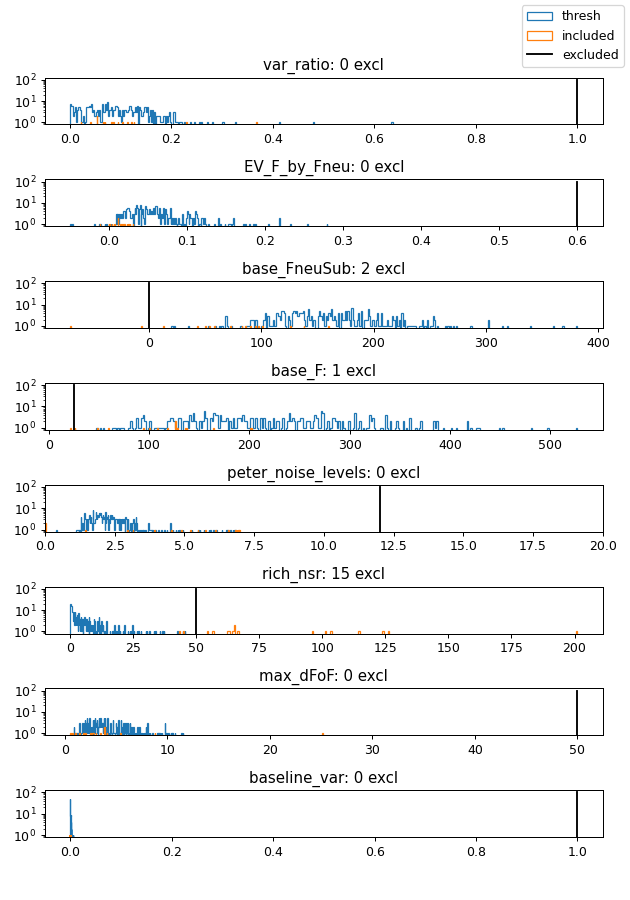

<IPython.core.display.Javascript object>


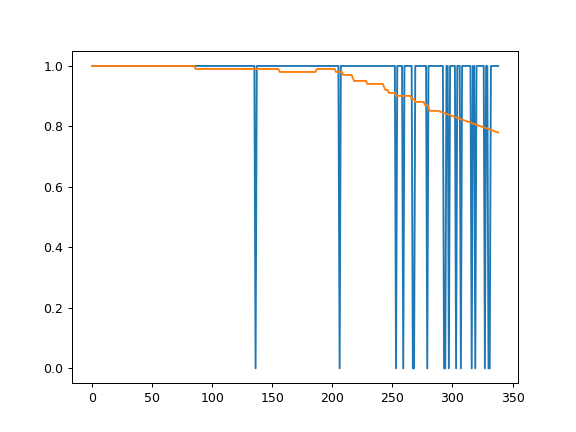

ROIs excluded: 17 / 339
ROIs included: 322 / 339


In [41]:
%matplotlib notebook

thresh = {
    'var_ratio': 1,
    'EV_F_by_Fneu': 0.6,
    'base_FneuSub': 0,
    'base_F': 25,
    'peter_noise_levels': 12,
    'rich_nsr': 50,
    'max_dFoF': 50,
    'baseline_var': 1,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F_toUse,
    Fneu_toUse,
    dFoF,
    dF,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

In [ ]:
I'll push changes to the repo. It just needs to take in a contiguous array

In [38]:
iscell_new = copy.copy(iscell)
iscell_new[iscell_new] = iscell_tqm

In [39]:
file_helpers.pickle_save(
    obj={
        "tqm": tqm,
        "iscell_tqm": iscell_tqm,
        "dFoF_params": dFoF_params
    },
    path_save=dir_save / 'trace_quality.pkl'
)

np.save(
    file= dir_save / 'iscell_NN_tqm.npy',
    arr=iscell_new
)